# 3. Neural Networks with PyTorch

In this notebook we build our first neural network with `PyTorch`.
For this you must first install PyTorch as described [here](https://pytorch.org/get-started/locally/).

We will work on the same dataset as the last two last weeks and try to predict which digit is shown on the given pixel values.

In [1]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True)

We know already from last time how the data looks:

In [2]:
X.head(3)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The label is a number between 0-9 representing the digit shown on the pixels.

In [3]:
y.head(3)

0    5
1    0
2    4
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

Before we start, we scale the data and divide it into train and test data:

In [4]:
from sklearn.model_selection import train_test_split

X_scaled = (X/255).astype('float32').values
y = y.astype('long').values
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)
X_train.shape, y_train.shape

((59500, 784), (59500,))

###  Model Training

The following lines checks for the availability of a GPU on the machine and sets the GPU as processing device (if available). No worries if you have no GPU available, CPU works also fine for our examples.

In [5]:
import torch
torch.manual_seed(0) # to ensure reproducibiltiy

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


To be able to use the data in PyTorch, we need to convert our data into PyTorch tensors.
Such a tensor is the PyTorch equivalent of a Numpy array. 
However, it has the additional benefit that they can be easily copied to the GPU (the `.to(device)` part in the code below) and that they support automatic backpropagation (more on this later):

In [7]:
train_x = torch.Tensor(X_train).float().to(device)
test_x = torch.Tensor(X_test).float().to(device)
train_y = torch.Tensor(y_train).long().to(device)
test_y = torch.Tensor(y_test).long().to(device)

We start with the following structure of a neural network with two hidden layers:
- Input layer of size 784 with sigmoid activation
- First hidden layer of size 128 with sigmoid activation
- Second hidden layer of size 64 with sigmoid activation
- Output layer of size 10 with softmax activation

A skeleton code for this network is given in the following class.

In [8]:
import torch.nn as nn

class DeepNeuralNetwork(nn.Module): # the class has to inherent from nn.Module
    def __init__(self):
        
        super(DeepNeuralNetwork, self).__init__()  # calling super constructor
        
        # defining layers
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)

    def forward(self, x):
        
        z1 = self.hidden1(x)
        a1 = torch.sigmoid(z1)
        z2 = self.hidden2(a1)
        a2 = torch.sigmoid(z2)
        z3 = self.output(a2)
        # note: we do not apply the softmax here!
        return z3

We can now create the model and move it to the device. We set it to train methode and check the number of parameters:

In [9]:
dnn = DeepNeuralNetwork()
dnn.to(device)            # copy the model to the device 
dnn.train()      # set model into training mode

DeepNeuralNetwork(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

We can now start training the network by implementing the training procedure. We train the network for 1000 epochs:

In [10]:
no_epochs = 1000
learning_rate = 0.3

loss_func = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(dnn.parameters(), lr=learning_rate)

losses = []
for iteration in range(no_epochs):
    
    optimizer.zero_grad()
    y_hat = dnn(train_x) # we predict on all data points (= batch gradient descent)
    
    loss = loss_func(y_hat, train_y) # calculate the loss
    loss.backward() # backpropagate the loss to calculate gradients
    optimizer.step() # update the weights using these gradients 

    losses.append(loss.item())
    if iteration % 100 == 0:
        print(f"Loss in epoch {iteration} is {loss.item()}")
           

Loss in epoch 0 is 2.3741440773010254
Loss in epoch 100 is 2.277350425720215
Loss in epoch 200 is 2.049368143081665
Loss in epoch 300 is 1.3549598455429077
Loss in epoch 400 is 0.9302161931991577
Loss in epoch 500 is 0.7136896252632141
Loss in epoch 600 is 0.5928159952163696
Loss in epoch 700 is 0.5187561511993408
Loss in epoch 800 is 0.4688713550567627
Loss in epoch 900 is 0.4326241910457611


Text(0, 0.5, 'loss')

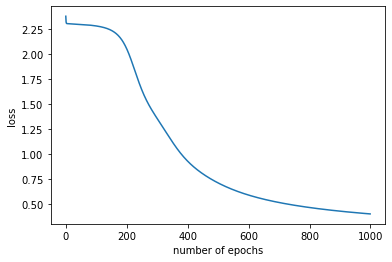

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(range(0, no_epochs), losses)
plt.xlabel('number of epochs')
plt.ylabel('loss')

### Predict on the test data

After the network is trained, we can use it to predict on the test data.

In [12]:
dnn.eval() 
y_pred = dnn(test_x)
predicted = torch.argmax(y_pred.data, 1)
correct = (predicted == test_y).sum().item()
accuracy = correct / len(test_x)

print(f"Accuarcy is {100. * accuracy}%")

Accuarcy is 88.28571428571429%


If we want to prediction of the network on a data point, we get the raw scores since we did not use a softmax activation layer in the output layer:

In [13]:
dnn(test_x[0])

tensor([-3.2510, -0.2967,  0.9061,  2.3132, -2.3849,  2.5244, -3.1187, -2.9710,
         6.9886,  0.9822], grad_fn=<AddBackward0>)

We can get the probabilies by applying a softmax to this output:

In [14]:
import torch.nn.functional as F
y_hat = dnn(test_x[0])
F.softmax(y_hat, dim=0)

tensor([3.4806e-05, 6.6785e-04, 2.2235e-03, 9.0811e-03, 8.2754e-05, 1.1216e-02,
        3.9729e-05, 4.6054e-05, 9.7421e-01, 2.3993e-03],
       grad_fn=<SoftmaxBackward0>)

The maximum index is in both cases the same, since the softmax does not change the ranking of the values.

In [15]:
x1 = dnn(test_x[0]) # raw scores
x2 = F.softmax(dnn(test_x[0]), dim=0) # probabilites
print(torch.argmax(x1))
print(torch.argmax(x2))

tensor(8)
tensor(8)


## Coding Tasks

### 1. Prepare the data
1. Create a new notebook in which you load the titanic dataset (see `data` folder).
2. Keep the following columns, filter out the rest: `Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, Survived`.
3. Drop all NAs values
4. One-hot encode the attributes `Sex` and `Embarked`.
5. Take `survived` as label and the other columns as features.
6. Do a train-test-split with 20% test data and set `random_state=0`

### 2. Train a neural network
1. Train a neural network with one hidden layer of size 5 and ReLu as activation for this layer (no activation on the output layer).
2. Use `CrossEntropyLoss` and a `SGD` optimizer with learning rate 0.001
3. Train the network for 200 epochs and print the loss every 20 epochs.
4. Plot the loss plot as shown above.
5. Predict on the test data with the trained network and measure accuracy.

### 3.  Bonus: Check for overfitting
- After each epoch, use the network to predict on the train data and on the test data. Measure the accuracy on both and remeber the values in seperate lists.
- After the training is finished, plot both curves in a graph with number of epochs on the x-axis and accuracy on y.
- Does the graph indicate overfitting of the model?